In [1]:
loading = True

In [2]:
from utils.utils import (
    lat_lon_to_epsg)
import uuid
import warnings
warnings.filterwarnings('ignore')
from datacube import Datacube
import xarray
import ipywidgets as widgets
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
from datacube.storage import masking  # Import masking capabilities
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dc = Datacube()

###need to add lat long and address search

if 'center' not in locals():
    center =[-34.42989,116.63979]
    
zoom = 2

product_summary = widgets.Output(layout={'border': '1px solid black'})
#dimensions = widgets.Output(layout={'border': '1px solid black'})



def generate_available_datasets_table():
    products_from_cube = dc.list_products()
    product_list = list(dc.list_products()['name'].values)
    product_description = list(dc.list_products()['description'].values)
    
    build_table = []
    
    config = load_config('./configIndex.txt')
    
    for num, product in enumerate(product_list):
        ds = dc.find_datasets(product=product,
                 latitude=tuple(config['lat']),
                 longitude=tuple(config['lon']),
                 time=tuple(sorted(config['time']))
                 )
        captured_dates = []
        for dataset in ds:
            captured_dates.append(dataset.time.begin.date())
        if len(captured_dates)>0:
            number_epochs = len(set(captured_dates))
            number_tiles =  len(captured_dates)

            captured_dates_sorted = sorted(captured_dates)

            start_date = captured_dates_sorted[0]
            end_date = captured_dates_sorted[len(captured_dates_sorted)-1]


            build_table.append([product,
                               product_description[num],
                               number_tiles,
                               number_epochs,
                               start_date,
                               end_date
                               ])
    build_table = pd.DataFrame(build_table,columns = ['Product Name', 
                                                    'Product Description',
                                                    'Number of Tiles',
                                                    'Number of Epochs',
                                                    'Start Date',
                                                    'End Date'])
    product_summary.clear_output()
    with product_summary:
        display(build_table)


def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data
    
def update_config(filename,variable,value):
    
    with open(filename, 'r') as f:
        data = json.load(f)
        data[variable] = value
        
    os.remove(filename)
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

m = Map(center=center, zoom=zoom)
m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
draw_control2 = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})

def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
        
        lon_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])
        lon_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])

        lat_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        lat_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        EPSG = lat_lon_to_epsg(lat_max,lon_min)
        
        
        
        #lat = {'lat' : (lat_max,lat_min),
        #          'lon' : (lon_max,lon_min)}
        update_config('./configIndex.txt',
                 'output_crs',
                 'epsg:' + EPSG)
            
        update_config('./configIndex.txt',
                 'lat',
                 (lat_max,lat_min))

        update_config('./configIndex.txt',
                 'lon',
                 (lon_max,lon_min))
        update_config('./configIndex.txt',
              'geoJSON',
              draw_control.last_draw
             )
        update_config('./configIndex.txt',
              'load_id',
              str(uuid.uuid4())
             )


    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
        
        lon_max = max([draw_control2.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][0]])
        lon_min = min([draw_control2.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][0]])

        lat_max = max([draw_control2.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][1]])
        lat_min = min([draw_control2.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control2.last_draw['geometry']['coordinates'][0][2][1]])
        EPSG = lat_lon_to_epsg(lat_max,lon_min)
        
        update_config('./configIndex.txt',
                 'output_crs',
                 'epsg:' + EPSG)
            
        update_config('./configIndex.txt',
                 'lat',
                 (lat_max,lat_min))

        update_config('./configIndex.txt',
                 'lon',
                 (lon_max,lon_min))
        
        update_config('./configIndex.txt',
                      'geoJSON',
                      draw_control2.last_draw
                     )
        update_config('./configIndex.txt',
              'load_id',
              str(uuid.uuid4())
             )


    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

dates = [datetime.date(1986,1,1) + datetime.timedelta(days =i) for i in range(1,12550)]
date_range = SelectionRangeSlider(options=dates,
                                          description = 'Date Range',
                                          disabled=False,
                                          layout = Layout(width='100%',height = '100px'))

def date_func(b):
    start_date,end_date = date_range.value
    update_config('./configIndex.txt',
                  'time',
                  (start_date.strftime("%Y-%m-%d"),
                   end_date.strftime("%Y-%m-%d")))

    generate_available_datasets_table()

button = widgets.Button(description="Query Cube",
                       button_Style = 'success',
                       layout=Layout(width='100%', height = '40px'))

button.on_click(date_func)
    
case_study_select = VBox([m,m2,product_summary, date_range, button])
    
#date_range.observe(date_func, names = 'value')

exe_load = True

accordion = Accordion(children=[case_study_select])
accordion.set_title(0, 'Select Case Study')
accordion

Accordion(children=(VBox(children=(Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', '…

In [3]:
%macro select_case_study_area 2

Macro `select_case_study_area` created. To execute, type its name (without quotes).
=== Macro contents: ===
from utils.utils import (
    lat_lon_to_epsg)
import uuid
import warnings
warnings.filterwarnings('ignore')
from datacube import Datacube
import xarray
import ipywidgets as widgets
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
from datacube.storage import masking  # Import masking capabilities
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dc = Datacube()

###need to add lat long and address search

if 'center' not in locals():
    center =[-34.42989,116.63979]
    
zoom = 2

product_summary = widgets.Output(layout={'border': '1px solid black'})
#dimensions = widget

In [4]:
%store select_case_study_area

Stored 'select_case_study_area' (Macro)


In [5]:
##Landsat 8 AWS
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_aws_landsat8(measurements = None, cloud_mask = False):

    def lat_lon_to_epsg(lat_max, lon_min):
        return str(int(32700 - round((45 + lat_max) / 90, 0) * 100 + round((183 + lon_min) / 6, 0)))

    
    data = load_config(case_study)

       
    lats= data['lat']
    longs= data['lon']
    global EPSG
    EPSG = lat_lon_to_epsg(lats[1],longs[0])
    
    ds = dc.load(product='ls8_level1_usgs', 
                 measurements = ('red','green','blue','nir','swir1','swir2','quality'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 output_crs='epsg:' + EPSG,
                 resolution = (-25,25))

    #filter for clouds
    clean_pixel_mask = masking.make_mask(
    ds.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)

    masked_cloud = ds.where(clean_pixel_mask)

    return masked_cloud

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded != config['load_id']:
            print ('Retrieving New Cube')
            ds = load_into_cube_aws_landsat8()
            loaded = config['load_id']

    else:
        print ('Retrieving Cube')
        ds = load_into_cube_aws_landsat8()
        loaded = config['load_id']

        
    target_dataset,desc = BandIndices.calculate_indices(ds,'NDVI')

    m3.add_layer(GeoJSON(data=geoJSON_Extent))



indicesa = ['NDVI','GNDVI','NDWI', 'NDMI', 'NDBI', 'NBR']

with info:
         print(desc)

indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset
    target_dataset, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

    info.clear_output()
    with info:
         print(desc)

indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
#EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(-1, 1)

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,int(EPSG))
        drill_cube = target_dataset.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1
        

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],int(EPSG))

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        dataMasked = target_dataset.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        #data_masked_mean.plot()

        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        xarray.plot.plot(data_masked_mean.interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    output_pandas.dropna(thresh=datasetID,inplace=True)
    out.clear_output()
    with out:
         display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [6]:
%macro band_indices_aws_landsat8 5

Macro `band_indices_aws_landsat8` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 8 AWS
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geo

In [7]:
%store band_indices_aws_landsat8

Stored 'band_indices_aws_landsat8' (Macro)


In [8]:
##Landsat 8 AWS WOFS Time series!!!
%pylab notebook
from importlib import reload  # Python 3.4+ only.
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
from utils import BandIndices

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))

from utils import Water_Classifier
Water_Classifier = reload(Water_Classifier)
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_aws_landsat8(measurements = None, cloud_mask = False):

    def lat_lon_to_epsg(lat_max, lon_min):
        return str(int(32700 - round((45 + lat_max) / 90, 0) * 100 + round((183 + lon_min) / 6, 0)))

    
    data = load_config(case_study)

       
    lats= data['lat']
    longs= data['lon']
    global EPSG
    EPSG = lat_lon_to_epsg(lats[1],longs[0])
    
    ds = dc.load(product='ls8_level1_usgs', 
                 measurements = ('red','green','blue','nir','swir1','swir2','quality'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 output_crs='epsg:' + EPSG,
                 resolution = (-25,25))

    #filter for clouds
    clean_pixel_mask = masking.make_mask(
    ds.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)
    masked_cloud = ds.where(clean_pixel_mask)


    return masked_cloud

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

indicesa = ['NDWI', 'WOFS']


indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )


if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded != config['load_id']:
            print ('Retrieving New Cube')
            ds = load_into_cube_aws_landsat8()
            loaded = config['load_id']
    else:
        print ('Retrieving Cube')
        ds = load_into_cube_aws_landsat8()
        loaded = config['load_id']

    water_dataset, desc = BandIndices.calculate_indices(ds,indices_buttons.value)
    target_dataset_1 = (water_dataset > 0.05).astype(np.float32)
    target_dataset = target_dataset_1.to_dataset(name='wofs')
    target_dataset = (target_dataset * 625) / 10000
    #dse = ds.resample(time='1M').median()
 
    # Load data the first time.
#    indices_func(True)
    
    m3.add_layer(GeoJSON(data=geoJSON_Extent))

   
def indices_func(change):
    global target_dataset
    if indices_buttons.value == 'NDWI':
        water_dataset, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

        target_dataset_1 = (water_dataset > 0.05).astype(np.float32)
        target_dataset = target_dataset_1.to_dataset(name='wofs')
        target_dataset = (target_dataset * 625) / 10000
    else:
          #dse = ds.resample(time='1M').median()
        dse = ds.fillna(-9999)
        target_dataset,desc = Water_Classifier.water_classifier(dse)
        target_dataset = (target_dataset * 625) / 10000

    info.clear_output()
    with info:
        print(desc)


with info:
         print(desc)
        
indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
#EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,int(EPSG))
        drill_cube = target_dataset.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1
        

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],int(EPSG))

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
                
        dataMasked = target_dataset.where(mask)
        #data_masked_max = dataMasked.resample(time='1M').max()
        
        orig = dse.where(mask)
        #orig_max = orig.resample(time='1M').median()
        
        no_data = orig.red.where(orig.red==-9999).count(dim = ['x','y'])
        
        # Area in Hectares
        no_data = (no_data * 625) / 10000
        total_area = (mask.sum() * 625) /10000
                
        data_masked = dataMasked.sum(dim = ['x','y'])
        
        other_masked = total_area - (data_masked + no_data)

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    plt.figure(num=datasetID, figsize=(10, 3.5))
    time_from = np.ravel(data_masked.time)
    
    plt.ylabel('Area (Ha)')
    color_scheme = '#1f77b4','#ff7f0e', '#2ca02c', '#d62728', 
    plt.set_title = label
    #plt.set_yscale('log')
    plt.stackplot(time_from,
                  data_masked.wofs.values, 
                  other_masked.wofs.values, 
                  no_data.values, 
                  colors = color_scheme,
                  labels=['Water','Dry','No Data'])
    plt.legend(loc='upper left')
    
    
    output_pandas = pd.concat([output_pandas,pd.DataFrame(data_masked.wofs.values,index = time_from, columns = [label])],axis = 1)
    #output_pandas.dropna(thresh=datasetID,inplace=True)
    out.clear_output()
#     with out:
#          display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

Populating the interactive namespace from numpy and matplotlib
No Case Study Selected


In [9]:
%macro water_stackplot_aws_landsat8 8

Macro `water_stackplot_aws_landsat8` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 8 AWS WOFS Time series!!!
get_ipython().run_line_magic('pylab', 'notebook')
from importlib import reload  # Python 3.4+ only.
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
from utils import BandIndices

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))

from utils import Water_Classifier
Water_Classifier = reload(Water_Classifier)
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polylin

In [10]:
%store water_stackplot_aws_landsat8 

Stored 'water_stackplot_aws_landsat8' (Macro)


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


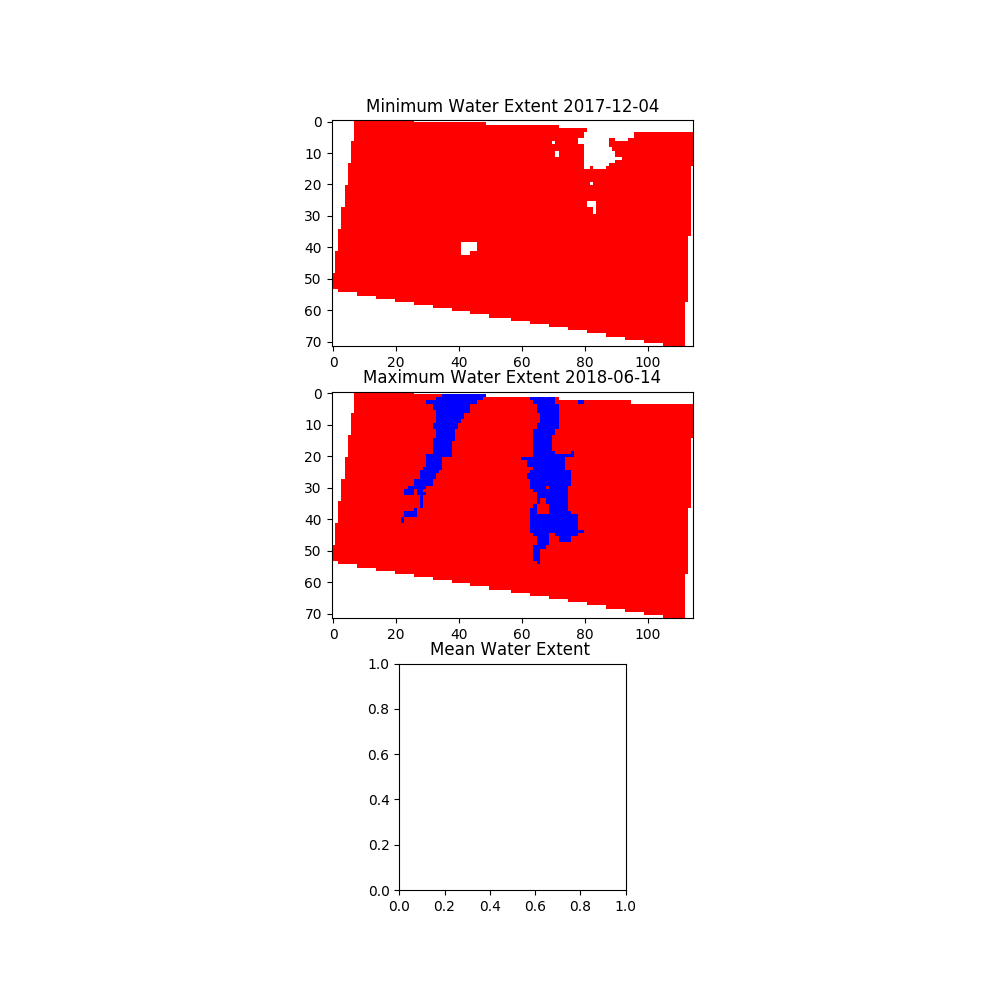

TypeError: Invalid dimensions for image data

In [2]:
##Landsat 8 AWS WOFS Time series!!!
%pylab notebook
from importlib import reload  # Python 3.4+ only.
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
from utils import BandIndices

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))

from utils import Water_Classifier
Water_Classifier = reload(Water_Classifier)
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})
info = widgets.Output(layout={'border': '1px solid black'})


def load_into_cube_aws_landsat8(measurements = None, cloud_mask = False):

    def lat_lon_to_epsg(lat_max, lon_min):
        return str(int(32700 - round((45 + lat_max) / 90, 0) * 100 + round((183 + lon_min) / 6, 0)))

    
    data = load_config(case_study)

       
    lats= data['lat']
    longs= data['lon']
    global EPSG
    EPSG = lat_lon_to_epsg(lats[1],longs[0])
    
    ds = dc.load(product='ls8_level1_usgs', 
                 measurements = ('red','green','blue','nir','swir1','swir2','quality'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 output_crs='epsg:' + EPSG,
                 resolution = (-25,25))

    #filter for clouds
    clean_pixel_mask = masking.make_mask(
    ds.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)
    masked_cloud = ds.where(clean_pixel_mask)


    return masked_cloud

#### Get geometry from config file draw polygon extent.
config =load_config(case_study)

geoJSON_Extent = config['geoJSON']
#m3.add_layer(GeoJSON(data=draw_control2.last_draw))

info_last_geom = ogr.CreateGeometryFromJson(str(geoJSON_Extent['geometry']))
if info_last_geom:
    zoom = 13
    center = [info_last_geom.Centroid().GetY(),info_last_geom.Centroid().GetX()]
    m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})
else:
    m3 = Map(center=center, zoom=zoom)
    draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

dc = Datacube()

indicesa = ['NDWI', 'WOFS']


indices_buttons = widgets.ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='' 
                    #tooltips=indices_description,
                    )


if 'loading' in locals():
    ds = None
    print ('No Case Study Selected')
    target_dataset,desc = None, 'No index selected'
else:
    geoJSON_Extent['properties']['style']['fillOpacity'] = 0
    geoJSON_Extent['properties']['style']['color'] = 'red'
    
    if 'loaded' in locals():
        if loaded != config['load_id']:
            print ('Retrieving New Cube')
            ds = load_into_cube_aws_landsat8()
            loaded = config['load_id']
    else:
        print ('Retrieving Cube')
        ds = load_into_cube_aws_landsat8()
        loaded = config['load_id']

    water_dataset, desc = BandIndices.calculate_indices(ds,indices_buttons.value)
    target_dataset_1 = (water_dataset > 0.05).astype(np.float32)
    target_dataset = target_dataset_1.to_dataset(name='wofs')
    #dse = ds.resample(time='1M').median()
    dse = ds.fillna(-9999) 
    # Load data the first time.
#    indices_func(True)
        

    m3.add_layer(GeoJSON(data=geoJSON_Extent))

   
def indices_func(change):
    global target_dataset
    if indices_buttons.value == 'NDWI':
        water_dataset, desc = BandIndices.calculate_indices(ds,indices_buttons.value)

        target_dataset_1 = (water_dataset > 0.05).astype(np.float32)

        target_dataset = target_dataset_1.to_dataset(name='wofs')

    else:
          #dse = ds.resample(time='1M').median()
        dse = ds.fillna(-9999)
        target_dataset,desc = Water_Classifier.water_classifier(dse)

    info.clear_output()
    with info:
        print(desc)


with info:
         print(desc)
        
indices_buttons.observe(indices_func, names = 'value')


dataP = load_config(case_study)

#EPSG = int(dataP['output_crs'].split(':')[1])
#EPSG = 3577
labels = []
def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,int(EPSG))
        drill_cube = target_dataset.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')

        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)

        #drill_cube.isel(x=[0],y=[0]).plot()
        label = str(indices_buttons.value) + ' point ' + str(datasetID)
        labels.append(label)
       
        xarray.plot.plot(drill_cube.isel(x=[0],y=[0]).interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1
        

    if geo_json['geometry']['type'] == 'Polygon':

        geom = transform_from_wgs_poly(geo_json['geometry'],int(EPSG))

        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)

        dataMasked = target_dataset.where(mask)
        
                #cleaned_dataset_month = dataMasked.resample(time='1M').median()
        orig = dse.where(mask)
        #no_data = orig.red.where(orig.red==-9999).count(dim = ['x','y'])
        
        cleaned_dataset_month = dataMasked.where(orig.red!=-9999)
        
        nan_mask = mask.astype('float')
        nan_mask[~mask] = np.nan
        
        nans = np.isnan(nan_mask)
        nancols = np.all(nans, axis=0) 
        nanrows = np.all(nans, axis=1) 
        
        firstcol = nancols.argmin() 
        firstrow = nanrows.argmin() 

        lastcol = len(nancols) - nancols[::-1].argmin() # 8, last index where not NAN
        lastrow = len(nanrows) - nanrows[::-1].argmin() # 10
        
        #no_data = no_data * 625
        total_area = mask.sum() * 625
                
#        data_masked = dataMasked.sum(dim = 'time')
        
        min_extent_time_ind = cleaned_dataset_month.wofs.where(cleaned_dataset_month.wofs == 0)\
                      .count(dim=['x','y']).argmax().values
        min_extent_acq = cleaned_dataset_month.wofs.isel(time=min_extent_time_ind)
        time_min = cleaned_dataset_month.time.isel(time=min_extent_time_ind)
        time_min_string = str(time_min.values)[0:10]
        min_extent_acq = min_extent_acq[firstrow:lastrow,firstcol:lastcol]
        
        # Find the acquisition with the most water.
        max_extent_time_ind = cleaned_dataset_month.wofs.where(cleaned_dataset_month.wofs > 0)\
                              .count(dim=['x','y']).argmax().values
        max_extent_acq = cleaned_dataset_month.wofs.isel(time=max_extent_time_ind)
        max_extent_acq = max_extent_acq[firstrow:lastrow,firstcol:lastcol]
        time_max = cleaned_dataset_month.time.isel(time=max_extent_time_ind)
        time_max_string = str(time_max.values)[0:10]
        
        
        mean_extent = cleaned_dataset_month.wofs.mean(dim=['x','y'])
        
        #other_masked = total_area - (data_masked + no_data)
        
        #data_masked_mean.no_data = data_masked_mean - 
        #data_masked_mean.plot()

        label = str(indices_buttons.value) + ' polygon ' + str(datasetID)
        labels.append(label)

        #xarray.plot.plot(data_masked_mean.interpolate_na(dim = 'time', method = 'nearest'), marker='*')
        #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", labels = labels)

        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1

    geoJSONs.append(geo_json)

    
#    if first_plot == True:
    global f,axarr

    f, axarr = plt.subplots(3, figsize=(10, 10))
    #f.suptitle('Fractional Cover Landsat 8')

    axarr[0].set_title( 'Minimum Water Extent ' + time_min_string)
    axarr[1].set_title( 'Maximum Water Extent ' + time_max_string)
    axarr[2].set_title( 'Mean Water Extent ')
    #axarr[2].set_title( 'Mean Water Extent')
    #axarr[3].set_title( 'Class Extent Change')
    from matplotlib.colors import from_levels_and_colors
    cmap, norm = from_levels_and_colors([0,0.04,2],['red','blue'])

    axarr[0].imshow(min_extent_acq,cmap=cmap, norm=norm)
    axarr[1].imshow(max_extent_acq, cmap=cmap, norm=norm)
    axarr[2].imshow(mean_extent, cmap=cmap, norm=norm)

        
    #output_pandas = pd.concat([output_pandas,pd.DataFrame(data_masked.wofs.values,index = time_from, columns = [label])],axis = 1)
    #output_pandas.dropna(thresh=datasetID,inplace=True)
    #out.clear_output()
#     with out:
#          display(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = widgets.VBox([info,indices_buttons,m3,out])

pixel_drill

In [12]:
%macro water_max_min_aws_landsat8 11

Macro `water_max_min_aws_landsat8` created. To execute, type its name (without quotes).
=== Macro contents: ===
##Landsat 8 AWS WOFS Time series!!!
get_ipython().run_line_magic('pylab', 'notebook')
from importlib import reload  # Python 3.4+ only.
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
import ipywidgets as widgets
import xarray
from utils import BandIndices

#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))

from utils import Water_Classifier
Water_Classifier = reload(Water_Classifier)
from utils.utils import (transform_from_wgs,
    transform_from_wgs_poly)
import json
from datacube import Datacube
from datacube.storage import masking  # Import masking capabilities

import warnings
warnings.filterwarnings('ignore')

if 'case_study' not in locals():
    global case_study
    case_study = './configIndex.txt'


from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline,

In [13]:
%store water_max_min_aws_landsat8 

Stored 'water_max_min_aws_landsat8' (Macro)
